In [24]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from plotnine import *
sb.set() # set the default Seaborn style for graphics

# Titanic Dataset

In [25]:
titanic_data=pd.read_csv('train.csv')


In [26]:
print('Dimensions of training data: ',titanic_data.shape)
titanic_data.head(3)

Dimensions of training data:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- Summary:
    - 10 predictors/features
    - 1 response variable
    - 1 ID column

# Response Variable: Survived

In [27]:
# convert the response categorical
response_copy=titanic_data['Survived'].copy()
titanic_data['Survived']=pd.Categorical(titanic_data['Survived'])

# rename response categories to more meaningful ones
titanic_data['Survived']=titanic_data['Survived'].cat.rename_categories({0:'dead',1:'alive'})


- Steps:
    - Converted response to categorical
    - renamed to more meaningful categories
    - kept a copy of the original for certain visualizations

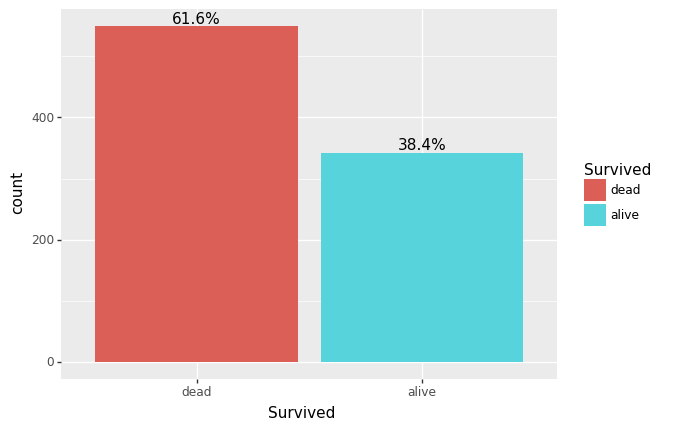

<ggplot: (-9223371946262305424)>

In [28]:
ggplot(titanic_data,aes(x='Survived',fill='Survived'))+geom_bar()+geom_text(
    aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )

- Observation:
    - slightly imbalanced

# Basic Exploratory data analysis

In [29]:
titanic_data.dtypes

PassengerId       int64
Survived       category
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
dtype: object

In [30]:
print("Number of levels:")
print()
for var in titanic_data.columns:
    print("{:<20}:{}".format(var,len(titanic_data[var].unique())))

Number of levels:

PassengerId         :891
Survived            :2
Pclass              :3
Name                :891
Sex                 :2
Age                 :89
SibSp               :7
Parch               :7
Ticket              :681
Fare                :248
Cabin               :148
Embarked            :4


- Obersvation:
    - all names are unique, though i won't assume it's completely useless
    - similarly, there are a **lot of levels for Ticket and Cabin variable**, but it may hold some patterens and information

### dealing with the NAs (temporarily)

In [31]:
titanic_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [32]:
    # fill Age variable with random integers between mean and max 
from random import randint
titanic_data['Age'].fillna(randint(int(titanic_data['Age'].min()),titanic_data['Age'].max()),inplace=True)
    # fill Cabin NAs with 'Missing' because there are too many
titanic_data['Cabin'].fillna('Missing',inplace=True)
    # fill embarked NAs with its mode
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0],inplace=True)

- Steps:
    - dealt with NAs temporarily to make visualizations
- Observation:
    - there are newborns who's Age's are in decimals and less than 1

In [33]:
print("Newborns:",list(titanic_data[titanic_data['Age']<1]['Age']))

Newborns: [0.83, 0.92, 0.75, 0.75, 0.67, 0.42, 0.83]


- will leave them as they are

### Visualizing Pclass, Sex, Embarked

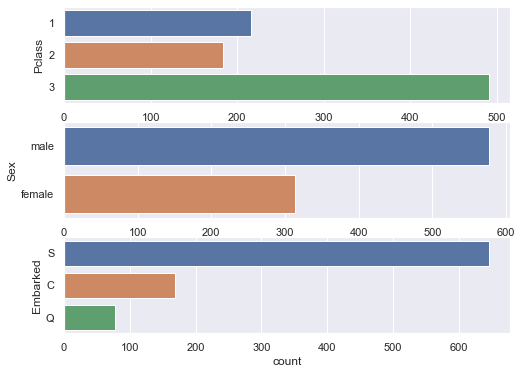

In [34]:
# uni-variate visuals
f, axes = plt.subplots(3,1 , figsize=(8, 6))
for i,var in enumerate(['Pclass','Sex','Embarked']):
    sb.countplot(data=titanic_data,y=var,ax=axes[i])

- Observation:
    - most passengers are from Pclass 3, are male and came from Southhampton

In [35]:
for var in ['Pclass','Sex','Embarked']:
    titanic_data[var]=pd.Categorical(titanic_data[var])

- converted 'Pclass','Sex','Embarked' into categorical types

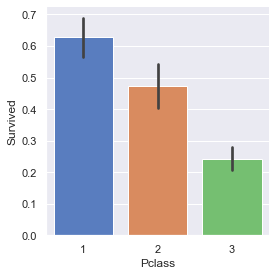

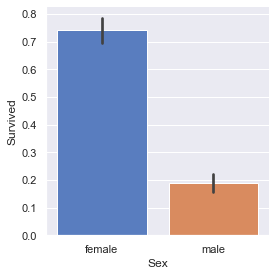

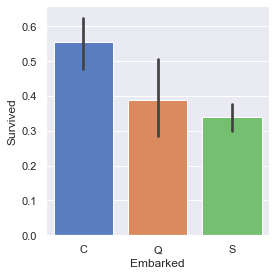

In [36]:
temp_data=pd.concat([titanic_data[['Pclass','Sex','Embarked']],response_copy],axis=1)
for i,var in enumerate(['Pclass','Sex','Embarked']):   
    sb.catplot(x=var,y='Survived',data=temp_data,kind='bar',palette='muted',height=4, aspect=1)

- Observations:
    - people from class 3, males and from Southampton are more likely to die
    - people from class 1 and females are more likely to live

### Visualising SibSp and Parch

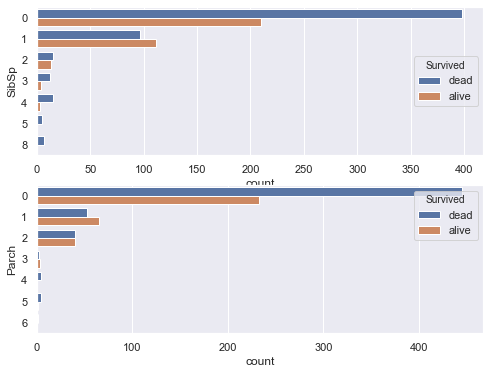

In [37]:
f, axes = plt.subplots(2,1 , figsize=(8, 6))
for i,var in enumerate(['SibSp','Parch']):
    sb.countplot(data=titanic_data,y=var,hue='Survived',ax=axes[i])

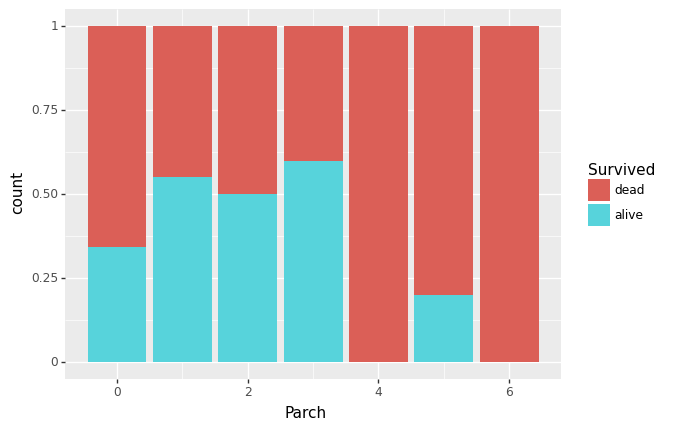

<ggplot: (-9223371946263931272)>

In [38]:
ggplot(titanic_data,aes(x='Parch',fill='Survived'))+geom_bar(position='fill')

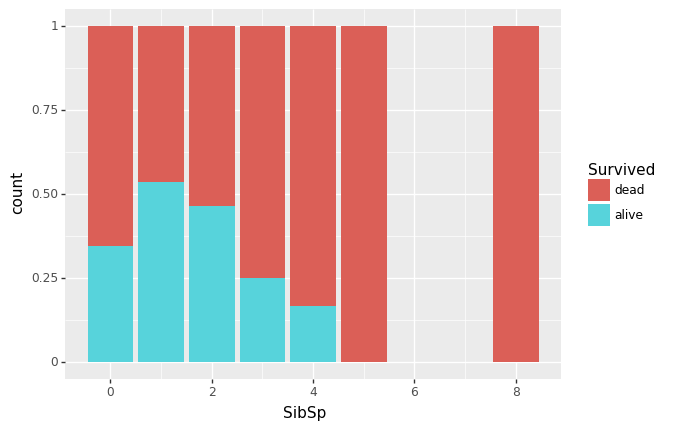

<ggplot: (-9223371946262815648)>

In [39]:
ggplot(titanic_data,aes(x='SibSp',fill='Survived'))+geom_bar(position='fill')

- Observation:
    - people who have one to two children are more likely to survive
    - people who are alone, or have too big of a family are more likely to die

### new feature: family_size
- Sums SibSp and Parch and includes the target passenger


In [40]:
titanic_data['family_size']=titanic_data['SibSp']+titanic_data['Parch']+1

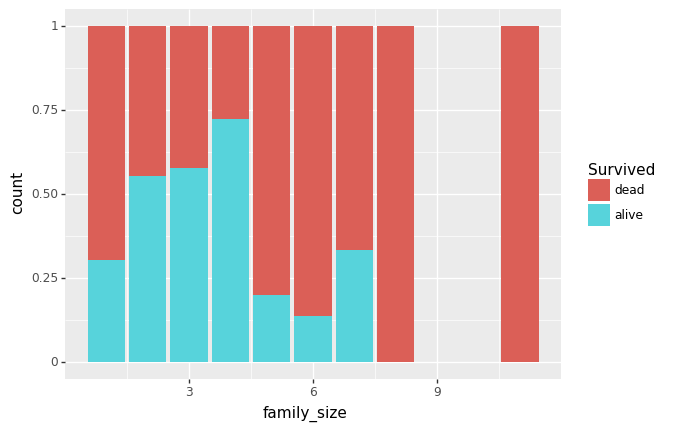

<ggplot: (-9223371946263876220)>

In [41]:
ggplot(titanic_data,aes(x='family_size',fill='Survived'))+geom_bar(position='fill')

- Observation:
    - smaller families a more likely to survive than larger ones
    - however, being alone indicates smaller chance of survival

### Visualising Age and Fare

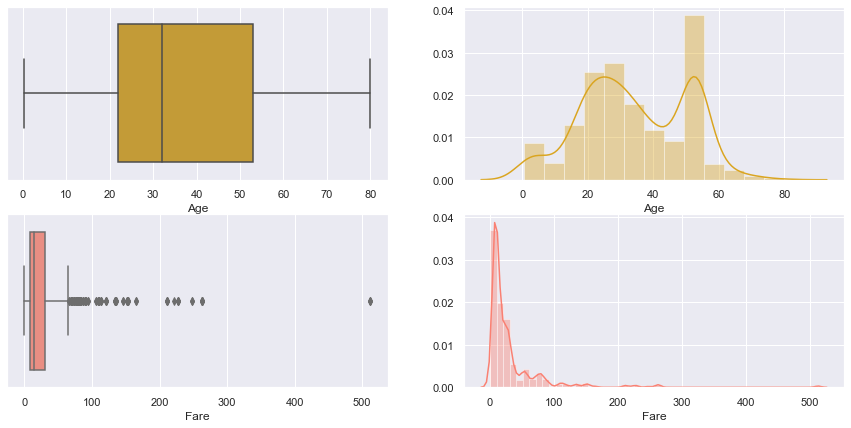

In [42]:
f, axes = plt.subplots(2,2 , figsize=(15, 7))
color_list=['goldenrod','salmon']
for i,var in enumerate(['Age','Fare']):
    sb.boxplot(titanic_data[var],ax=axes[i,0],color=color_list[i])
    sb.distplot(titanic_data[var],ax=axes[i,1],color=color_list[i])

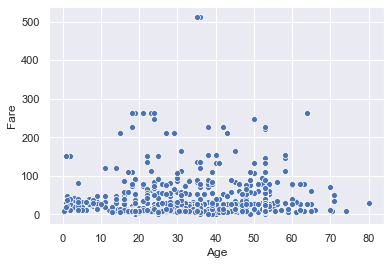

In [43]:
sb.scatterplot(x='Age', y='Fare',data=titanic_data)

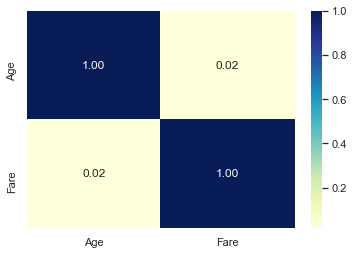

In [44]:
sb.heatmap(titanic_data[['Age','Fare']].corr(),annot=True,cmap="YlGnBu",fmt='.2f')

- Observation:
    - most people are aged between 22 and 35
    - most people pay between 10 and 30
    - there is no correlation between Age and Fare

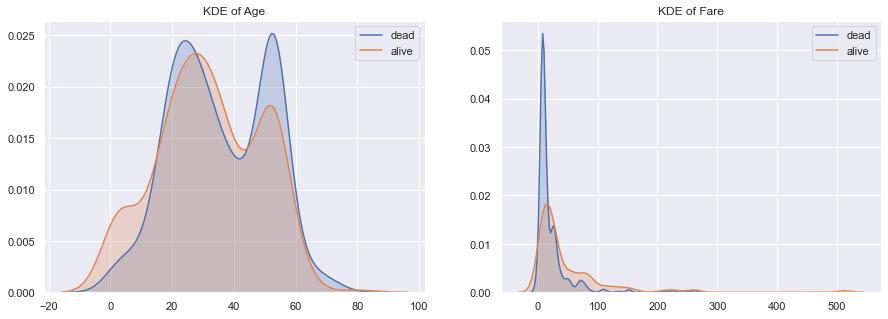

In [45]:
f, axes = plt.subplots(1,2 , figsize=(15, 5))
for i,var in enumerate(['Age','Fare']):
    for level in titanic_data['Survived'].unique():
        sb.kdeplot(titanic_data[titanic_data['Survived']==level][var],shade=True,label=level,ax=axes[i]).set(title='KDE of '+var)

- Obersvation:
    - children under the age of 10 are more likely to survive 
    - people who paid more for their fare are more likely to survive

### Visualising Cabin variable

In [46]:
titanic_data['Cabin'].unique()

array(['Missing', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [47]:
def multiple_cabins(target):
    if target=='Missing':
        return False
    elif len(target)>4:
        return True
    else:
        return False          

In [48]:
titanic_data[titanic_data['Cabin'].apply(lambda x: multiple_cabins(x))].sort_values(['Cabin'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size
872,873,dead,1,"Carlsson, Mr. Frans Olof",male,33.00,0,0,695,5.0000,B51 B53 B55,S,1
679,680,alive,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.00,0,1,PC 17755,512.3292,B51 B53 B55,C,2
742,743,alive,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,5
311,312,alive,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,5
118,119,dead,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C,2
299,300,alive,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C,2
789,790,dead,1,"Guggenheim, Mr. Benjamin",male,46.00,0,0,PC 17593,79.2000,B82 B84,C,1
763,764,alive,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.00,1,2,113760,120.0000,B96 B98,S,4
435,436,alive,1,"Carter, Miss. Lucile Polk",female,14.00,1,2,113760,120.0000,B96 B98,S,4
802,803,alive,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,4


- Observation:
    - there are passengers that have the same combination of cabins but pay drastically different fares. those are likely erroneous 

In [31]:
titanic_data['separate_rooms']=titanic_data['Cabin'].apply(lambda x: 1 if multiple_cabins(x) else 0)
titanic_data['separate_rooms']=pd.Categorical(titanic_data['separate_rooms'])

In [32]:
titanic_data['separate_rooms'].value_counts()

0    867
1     24
Name: separate_rooms, dtype: int64

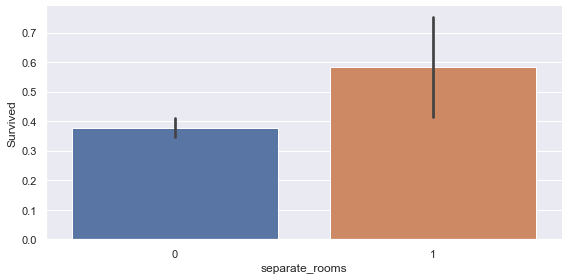

In [33]:
temp_data=pd.concat([titanic_data['separate_rooms'],response_copy],axis=1)
sb.catplot(x='separate_rooms',y='Survived',data=temp_data,kind='bar',height=4, aspect=2)

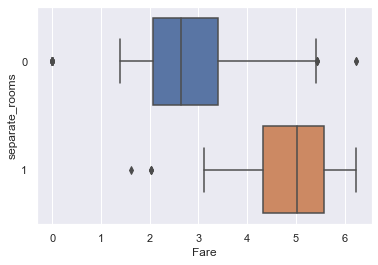

In [34]:
sb.boxplot(data=titanic_data,y='separate_rooms',x='Fare')

- Observation:
    - interestingly people who had multiple rooms had higher change of survival
    - but that could be due to the fact that they tended to pay more if they had multiple rooms
    - likely **not a useful feature** because Fare variable already captures this information and the levels here is too imbalanced

In [35]:
titanic_data['Cabin']=titanic_data['Cabin'].apply(lambda x: x if x=='Missing' else x[0])

- Cabin Variable:
    - reduced its cardinality by grouping alphabets together
    - levels have 2 alphebets; will just take the first occuring one

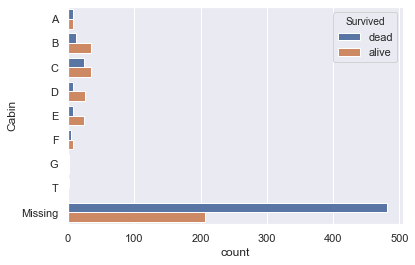

In [36]:
sb.countplot(data=titanic_data,y='Cabin',hue='Survived',order=['A','B','C','D','E','F','G','T','Missing'])

- Observation:
    - some levels are quite rare

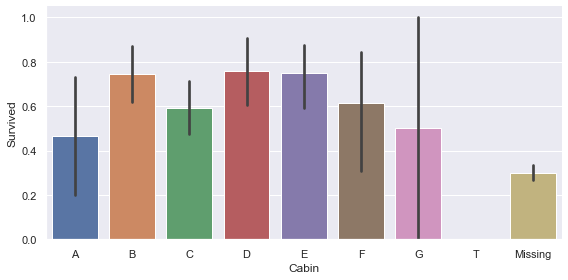

In [37]:
temp_data=pd.concat([titanic_data['Cabin'],response_copy],axis=1)
sb.catplot(x='Cabin',y='Survived',data=temp_data,kind='bar',height=4, aspect=2,order=['A','B','C','D','E','F','G','T','Missing'])

- Observation:
    - people with no cabin tagged are more likely to die
    - Cabins B,C,D,E are more likely to survive


### Visualising Ticket variable

In [38]:
def letters_present(target):
    for i in target:
        if i.isalpha():
            return True
    return False

def extract_letters(target):
    result=''
    for i in target:
        if i.isalpha():
            result+=i
    return result
    


In [39]:
titanic_data['ticket_letters']=titanic_data['Ticket'].apply(lambda x: 'present' if letters_present(x) else 'absent')

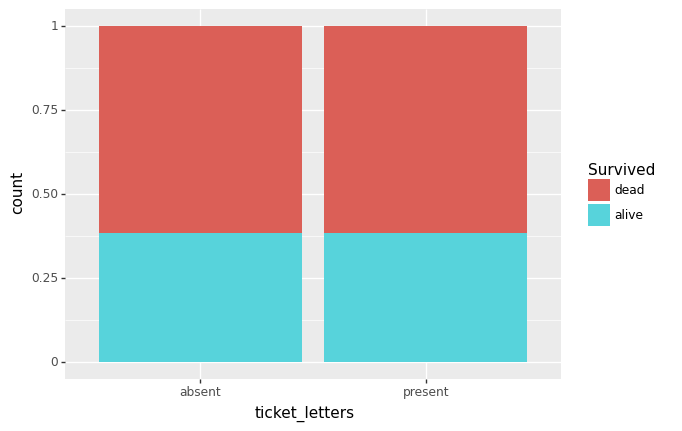

<ggplot: (-9223371839454457416)>

In [40]:
ggplot(titanic_data,aes(x='ticket_letters',fill='Survived'))+geom_bar(position='fill')

- Observation:
    - whether letters were present or not in the ticket didn't matter

In [41]:
titanic_data['test']=titanic_data['Ticket'].apply(lambda x: extract_letters(x) if letters_present(x) else 'absent')

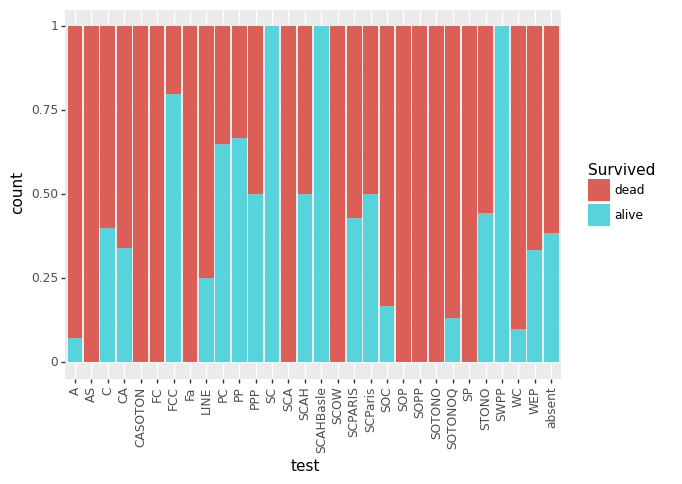

<ggplot: (-9223371839454500372)>

In [42]:
ggplot(titanic_data,aes(x='test',fill='Survived'))+geom_bar(position='fill')+  theme(axis_text_x=element_text(angle=90))

In [43]:
titanic_data['test'].value_counts()

absent       661
PC            60
CA            41
A             28
STONO         18
SOTONOQ       15
WC            10
SCPARIS        7
SOC            6
FCC            5
C              5
LINE           4
SCParis        4
WEP            3
PP             3
SOPP           3
SOTONO         2
SWPP           2
PPP            2
SCAH           2
SCOW           1
SCA            1
SOP            1
AS             1
CASOTON        1
Fa             1
SC             1
SP             1
SCAHBasle      1
FC             1
Name: test, dtype: int64

- Observations:
    - looking at the levels like 'absent', 'PC' and 'CA', where the sample size are largest, their dead/alive ratio are very close to that of the population
    - other levels likely had varying proportions by chance due to small sample size
    - this variable likely has close to **no effect on survival**

### Visualising Name variable

In [44]:
print("Number of unique names: ",len(titanic_data['Name'].unique()))

Number of unique names:  891


In [45]:
titanic_data['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

- insight:
    - looking at the Name column, there seems to be a some prefixes:
        - Master
        - Mr
        - Miss (and etc.)
    - they always end with a fullstop and begin with a space


In [46]:
def extract_prefixes(target):
    temp=target.split('.')[0]
    return temp.split(' ')[-1]

In [47]:
titanic_data['Name'].apply(lambda x: extract_prefixes(x)).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Countess      1
Capt          1
Don           1
Lady          1
Mme           1
Jonkheer      1
Sir           1
Name: Name, dtype: int64

- Observation:
    - the rare levels can be classified with the majority based on their prefix:
        - Dr,Rev,Col, Major, Capt, Sir, Don; Mr (Mode)
        - Mlle, Ms, Countess, Jonkheer, MMe,Lady;Miss ( Mode)

In [48]:
titanic_data['prefix']=titanic_data['Name'].apply(lambda x: extract_prefixes(x))

In [49]:
def reclassify_prefix_by_gender(target):
    if target in ['Mlle', 'Ms', 'Countess', 'Jonkheer', 'Mme','Lady']:
        return 'Miss'
    elif target in ['Miss','Mr','Master', 'Mrs']:
        return target
    else:
        return 'Mr'
        

In [50]:
titanic_data['prefix']=titanic_data['prefix'].apply(lambda x: reclassify_prefix_by_gender(x))

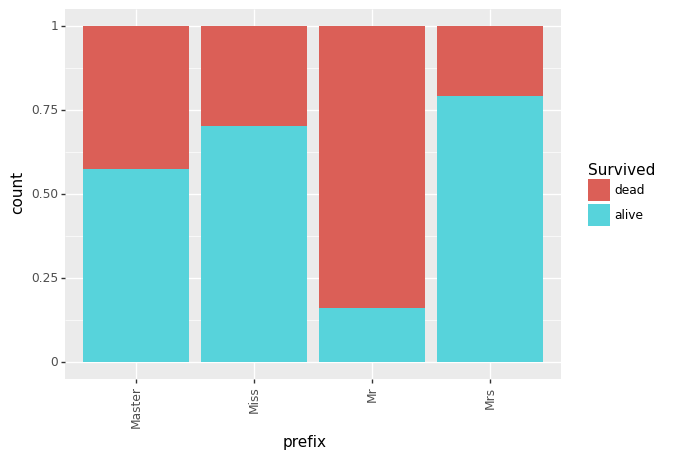

<ggplot: (-9223371839454181724)>

In [51]:
ggplot(titanic_data,aes(x='prefix',fill='Survived'))+geom_bar(position='fill')+  theme(axis_text_x=element_text(angle=90))

- Observations:
    - there are way too many levels, some of which  are quite rare and will not have impact
- Decision:
    - group rare levels together to reduce noise and cardinality 

In [52]:
titanic_data['prefix']=pd.Categorical(titanic_data['prefix'])

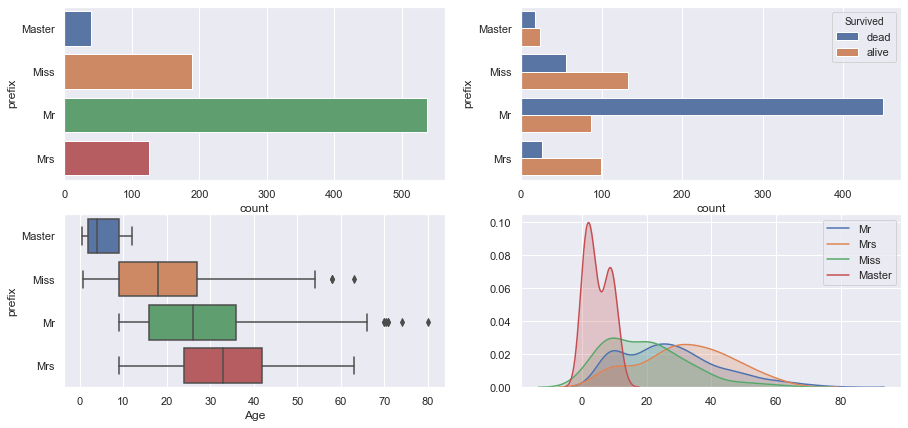

In [53]:
f, axes = plt.subplots(2,2 , figsize=(15, 7))
sb.countplot(data=titanic_data,y='prefix',ax=axes[0,0])
sb.countplot(data=titanic_data,y='prefix',hue='Survived',ax=axes[0,1])
sb.boxplot(data=titanic_data,x='Age',y='prefix',ax=axes[1,0])
for level in titanic_data['prefix'].unique():
    sb.kdeplot(titanic_data[titanic_data['prefix']==level]['Age'],ax=axes[1,1],shade=True,label=level)

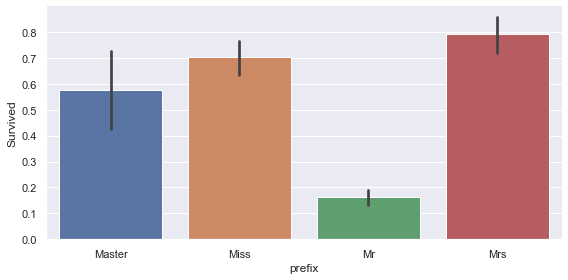

In [54]:
temp_data=pd.concat([titanic_data['prefix'],response_copy],axis=1)
sb.catplot(x='prefix',y='Survived',data=temp_data,kind='bar',height=4, aspect=2)

- Observation:
    - prefix is not only a good predictor for survival('Mr' are more likely to die)
    - it also **predicts well for age** as well

# Data Preparation

In [52]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from plotnine import *
sb.set() # set the default Seaborn style for graphics

In [53]:
# read data
titanic_train=pd.read_csv('train.csv')
titanic_test=pd.read_csv('test.csv')
print('Training set dimensions:',titanic_train.shape)
print('Test set dimensions:',titanic_test.shape)

Training set dimensions: (891, 12)
Test set dimensions: (418, 11)


In [54]:
# combine training and test set to do processing together
titanic_processing=pd.concat([titanic_train,titanic_test],axis=0,sort=True).reset_index(drop=True)

In [55]:
titanic_processing.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

- Observation:
    - NAs present in 4 features
    - NAs in Survived refer to the test set

In [56]:
titanic_processing.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

### variable: Survived


In [57]:
titanic_processing['Survived']=pd.Categorical(titanic_processing['Survived'])

- Step: 
    - Response converted to categorical
    - 0 is dead, 1 is alive

### variable: Pclass

In [58]:
# titanic_processing=pd.get_dummies(titanic_processing,columns=['Pclass'],prefix='Pclass')
titanic_processing['Pclass']=pd.Categorical(titanic_processing['Pclass'])

### variable: Name        , engineered feature: prefix

In [59]:
def extract_prefixes(target):
    temp=target.split('.')[0]
    return temp.split(' ')[-1]
def reclassify_prefix_by_gender(target):
    if target in ['Miss','Mlle', 'Ms', 'Countess', 'Jonkheer', 'Mme','Lady']:
        return 'Mrs'
    elif target in ['Mr','Master', 'Mrs']:
        return target
    else:
        return 'Mr'
titanic_processing['prefix']=titanic_processing['Name'].apply(lambda x: extract_prefixes(x))
titanic_processing['prefix']=titanic_processing['prefix'].apply(lambda x: reclassify_prefix_by_gender(x))
titanic_processing.drop(['Name'],axis=1,inplace=True)

- Steps:
    - engineered categorical feature; prefix, from name variable:
        - classes: Mr, Mrs, Master
        - since Miss and Mrs have very similar survival rate i will group them
        - the remaining prefixes are quite rare so i will group they to Mr and Mrs respectively( by gender)
    - drop original feature

### variable: Sex

In [60]:
titanic_processing['Sex']=pd.Categorical(titanic_processing['Sex'])
titanic_processing['Sex']=titanic_processing['Sex'].cat.rename_categories({'male':1,'female':0})

- Steps:
    - converted to categorical
    - label encode male as 1 and female as 0

### variable: SibSp and Parch      , engineered feature: family_size

In [61]:
titanic_processing['family_size']=titanic_processing['SibSp']+titanic_processing['Parch']+1

- Steps:
    - SibSp and Parch kept as integer rather than binning or categorizing which may cause bias and loss of information
    - having a family member around could aid in survival while having too many may lead to death, so
        family_size could capture this information
    - add one to include the target passenger themselve

### variable: Ticket

In [62]:
titanic_processing.drop(['Ticket'],axis=1,inplace=True)

- Steps:
    - ticket dropped because it is not predictive of survival

### variable: Cabin

In [63]:
titanic_processing['Cabin'].fillna('Missing',inplace=True)
titanic_processing['Cabin']=titanic_processing['Cabin'].apply(lambda x: x if x=='Missing' else x[0])
#titanic_processing=pd.get_dummies(titanic_processing,columns=['Cabin'])
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
titanic_processing['Cabin_encoded']=labelencoder.fit_transform(titanic_processing['Cabin'])
cabin_mapping=titanic_processing.groupby(['Cabin_encoded','Cabin'])

- Steps:
    - NAs assigned as 'Missing'
    - the others are assigned theri first occuring letter cabin
    - treated as categorical 
    - ONE HOT ENCODED

### variable: fare

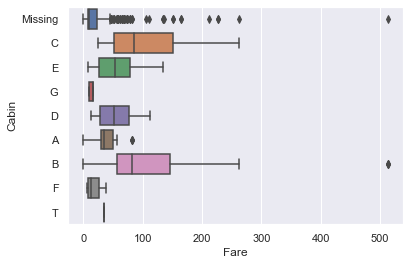

In [64]:
sb.boxplot(data=titanic_processing,y='Cabin',x='Fare')

- Observations:
    - Cabin does seem to be a strong indicator of Fare

In [65]:
titanic_processing[titanic_processing['Fare'].isna()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,prefix,family_size,Cabin_encoded
1043,60.5,Missing,S,NaN,0,1044,3,1,0,NaN,Mr,1,7


In [66]:
titanic_processing.loc[titanic_processing['Fare'].isna(),'Fare']=titanic_processing.loc[titanic_processing['Fare'].isna(),'Fare'].apply(lambda x: titanic_processing['Fare'].median())

- Steps:
    - Replace Fare NAs with median based on Cabin

In [67]:
titanic_processing['Fare']=titanic_processing['Fare'].apply( lambda x: np.log1p(x))

- steps:
    - log of fare taken to reduce skew

### variable: Embarked

In [68]:
titanic_processing[titanic_processing['Embarked'].isna()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,prefix,family_size,Cabin_encoded
61,38.0,B,NaN,4.394449,0,62,1,0,0,1.0,Mrs,1,1
829,62.0,B,NaN,4.394449,0,830,1,0,0,1.0,Mrs,1,1


In [69]:
titanic_processing['Embarked'].fillna(titanic_processing['Embarked'].mode()[0],inplace=True)
#titanic_processing=pd.get_dummies(titanic_processing,columns=['Embarked'])
labelencoder = LabelEncoder()
titanic_processing['Embarked_encoded']=labelencoder.fit_transform(titanic_processing['Embarked'])
embarked_mapping=titanic_processing.groupby(['Embarked_encoded','Embarked'])

- Steps:
    - there are only 2 NAs, of which will be filled with the mode; Southampton, 'S'
    - one hot encoded

### variable: Age

In [70]:
for level in titanic_processing['prefix'].unique():
    median_age=titanic_processing[titanic_processing['prefix']==level]['Age'].median()
    titanic_processing.loc[titanic_processing['prefix']==level,'Age']=titanic_processing.loc[titanic_processing['prefix']==level,'Age'].apply(lambda x: median_age if pd.isna(x) else x)

- Steps:
    - replaced NAs with median age based on their respective prefixes 
    - kepted as float
    
- IMPT note:
    - titanic_processing.loc[titanic_processing['prefix']==level,'Age'] works because it's a single operation
    -titanic_processing[titanic_processing['prefix']==level]['Age'] will not because it's a chained operation which will give a warning

### variable: prefix


In [71]:
#titanic_processing=pd.get_dummies(titanic_processing,columns=['prefix'])
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
titanic_processing['prefix_encoded']=labelencoder.fit_transform(titanic_processing['prefix'])
prefix_mapping=titanic_processing.groupby(['prefix_encoded','prefix'])

- Steps:
    - one hot encode

### variable: PassengerID

In [72]:
titanic_processing.drop(['PassengerId'],axis=1,inplace=True)

- Steps:
    - dropped

### consolidating cleaned data

In [73]:
titanic_processing.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'prefix', 'family_size', 'Cabin_encoded',
       'Embarked_encoded', 'prefix_encoded'],
      dtype='object')

In [74]:
titanic_processing.dtypes

Age                  float64
Cabin                 object
Embarked              object
Fare                 float64
Parch                  int64
Pclass              category
Sex                 category
SibSp                  int64
Survived            category
prefix                object
family_size            int64
Cabin_encoded          int32
Embarked_encoded       int32
prefix_encoded         int32
dtype: object

In [75]:
# treat every feature as categorical except fare and age
for var in ['Parch','SibSp','family_size','Cabin_encoded','Embarked_encoded','prefix_encoded']:
    titanic_processing[var]=pd.Categorical(titanic_processing[var])

In [76]:
# scale the numeric variables to speed up modelling
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()
titanic_processing[['Age', 'Fare']]=MMscaler.fit_transform(titanic_processing[['Age', 'Fare']])

In [77]:
titanic_cleaned=titanic_processing[['Age', 'Fare', 'Parch', 'Pclass','Sex', 'SibSp',
       'Survived', 'family_size', 'Cabin_encoded',
       'Embarked_encoded', 'prefix_encoded']].copy()

In [78]:
# check data types
titanic_cleaned.dtypes

Age                  float64
Fare                 float64
Parch               category
Pclass              category
Sex                 category
SibSp               category
Survived            category
family_size         category
Cabin_encoded       category
Embarked_encoded    category
prefix_encoded      category
dtype: object

In [79]:
titanic_test_cleaned=titanic_cleaned[titanic_cleaned['Survived'].isna()]
titanic_train_cleaned=titanic_cleaned[~titanic_cleaned['Survived'].isna()]

- Steps:
    - split to the original training and test sets given

In [80]:
y_titanic_train_cleaned=titanic_train_cleaned['Survived']
X_titanic_train_cleaned=titanic_train_cleaned.drop(['Survived'],axis=1)
X_titanic_test_cleaned=titanic_test_cleaned.drop(['Survived'],axis=1)

- Steps:
    - separate predictor from response variable

# Training the models

- Observation:
    - taking the log of fare actually caused the test set to perform worse which is an indication of overfitting
    - label encoding performed better than one hot encoding

In [132]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV,learning_curve

In [133]:
kfold=StratifiedKFold(n_splits=10)

- Steps:
    - since there is a class imabalance(more people are dead than alive),
        we use stratified k fold so that the **proportion of each class in each fold is preserved**

In [134]:
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_titanic_train_cleaned,y_titanic_train_cleaned,cv=kfold,n_jobs=-1))
    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
result_table=pd.DataFrame({'Algorithm':['SVC','RandomForest','ExtraTrees','GradientBoosting'],
                          'Cross_val_mean':cv_means,
                          'Cross_val_std':cv_std})



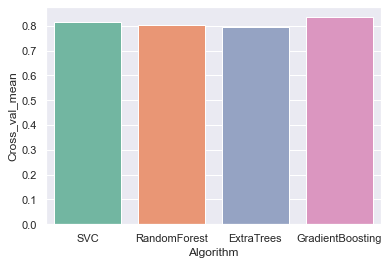

In [135]:
sb.barplot(x='Algorithm',y='Cross_val_mean',data=result_table,palette='Set2')

- Observation:
    - Gradient boosting outperforms the other models

# Hyperparameter tuning

### load tuned models with pickle

In [41]:
# !pip install joblib
import joblib
GS_ranFor=joblib.load('GS_ranFor.pkl')
GS_graBoo=joblib.load('GS_graBoo.pkl')
GS_SVM=joblib.load('GS_SVM.pkl')
GS_exTrees=joblib.load('GS_exTrees.pkl')

### Random Forest

ranFor=RandomForestClassifier()

ranFor_paramgrid={"max_depth":[None, 8,15],
                 "max_features":[4,6,8],
                 "min_samples_split":[2,3,4],
                 "min_samples_leaf":[3,5],
                 "n_estimators":[300,500,1000],
                 "criterion":["gini"]}

GS_ranFor=GridSearchCV(ranFor,param_grid=ranFor_paramgrid,cv=kfold,scoring='accuracy',n_jobs=-1)

GS_ranFor.fit(X_titanic_train_cleaned,y_titanic_train_cleaned)



- Best parameters and best score:

In [140]:
best_ranFor=GS_ranFor.best_estimator_
print(best_ranFor)
print("Score: {:.5f}".format(GS_ranFor.best_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Score: 0.84287


### Gradient Boosting

graBoo=GradientBoostingClassifier()

graBoo_paramgrid={'loss':['deviance'],
                 'n_estimators':[300,500,1000],
                 'learning_rate':[0.05,0.1,0.3],
                 'max_depth':[None, 8,15],
                 'min_samples_leaf':[100,150],
                 'max_features':[4,6,8]}

GS_graBoo=GridSearchCV(graBoo,param_grid=graBoo_paramgrid,scoring='accuracy',n_jobs=-1,cv=kfold)

GS_graBoo.fit(X_titanic_train_cleaned,y_titanic_train_cleaned)

- Best parameters and best score:

In [141]:
best_graBoo=GS_graBoo.best_estimator_
print(best_graBoo)
print("Score: {:.5f}".format(GS_graBoo.best_score_))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=8,
                           max_features=6, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Score: 0.83502


### Support Vector Machine

SVM=SVC(probability=True)

SVM_paramgrid={'kernel':['rbf'],
                 'gamma':[0.001,0.01,0.1,1],
                 'C':[1,10,50,100,200,300,1000]}

GS_SVM=GridSearchCV(SVM,param_grid=SVM_paramgrid,scoring='accuracy',n_jobs=-1,cv=kfold)

GS_SVM.fit(X_titanic_train_cleaned,y_titanic_train_cleaned)

- Best parameters and best score:

In [142]:
best_SVM=GS_SVM.best_estimator_
print(best_SVM)
print("Score: {:.5f}".format(GS_SVM.best_score_))

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Score: 0.83389


### Extra Trees

exTrees=ExtraTreesClassifier()

exTrees_paramgrid={"max_depth":[None, 8,15],
                 "max_features":[4,6,8],
                 "min_samples_split":[2,3,4],
                 "min_samples_leaf":[3,5],
                 "n_estimators":[300,500,1000],
                 "criterion":["gini"]}

GS_exTrees=GridSearchCV(exTrees,param_grid=exTrees_paramgrid,scoring='accuracy',n_jobs=-1,cv=kfold)

GS_exTrees.fit(X_titanic_train_cleaned,y_titanic_train_cleaned)

- Best parameters and best score:

In [143]:
best_exTrees=GS_exTrees.best_estimator_
print("Best parameters:")
print(best_exTrees)
print("Score: {:.5f}".format(GS_exTrees.best_score_))

Best parameters:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=8, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Score: 0.83502


## Saving the models- executed

import joblib
joblib.dump(GS_ranFor,'GS_ranFor.pkl')
joblib.dump(GS_SVM,'GS_SVM.pkl')
joblib.dump(GS_graBoo,'GS_graBoo.pkl')
joblib.dump(GS_exTrees,'GS_exTrees.pkl')

# Plot Learning curve 

- the difference in accuracy between training and test can indicate the degree of overfitting

In [46]:
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,n_jobs=-1,train_sizes=np.linspace(0.1,1,5)):
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    train_sizes,train_scores,test_scores=learning_curve(estimator ,X , y,
                                                      cv=cv, 
                                                      n_jobs=n_jobs,
                                                      train_sizes=train_sizes)
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes,
                     train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std, alpha= 0.1 ,color='y')
    plt.fill_between(train_sizes,
                     test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std, alpha= 0.1 ,color='b')
    
    plt.plot(train_sizes,train_scores_mean,'o-',color='y',
            label='Training scores')
    plt.plot(train_sizes,test_scores_mean,'o-',color='b',
            label='Cross validation scores')
    
    plt.legend(loc='best')
    return plt
    
    
    

<module 'matplotlib.pyplot' from 'C:\\Users\\tanch\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

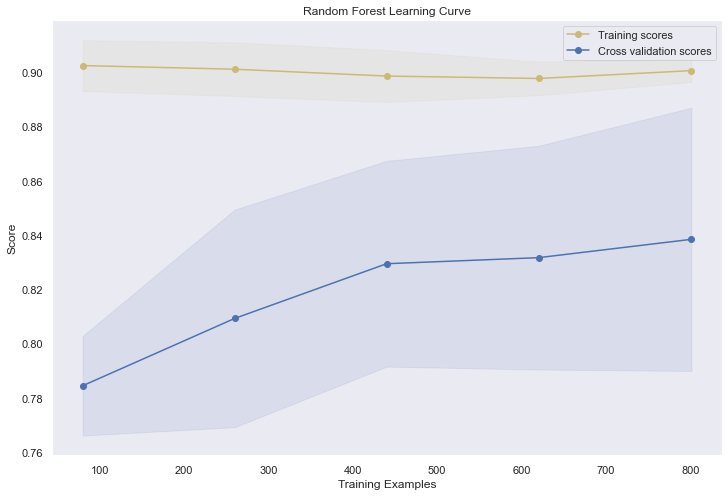

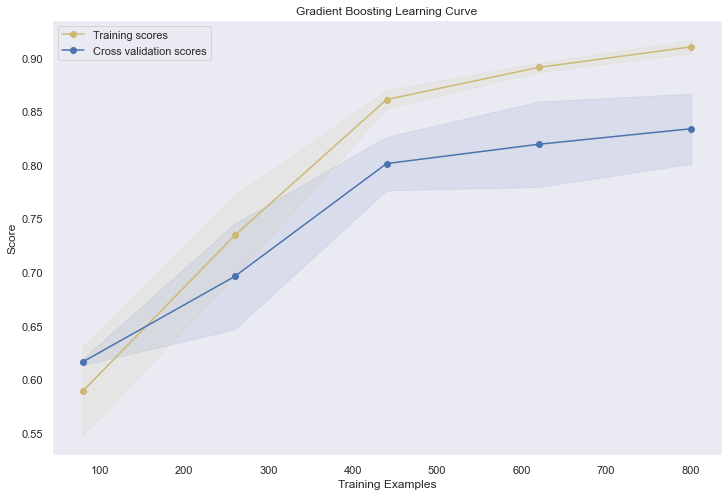

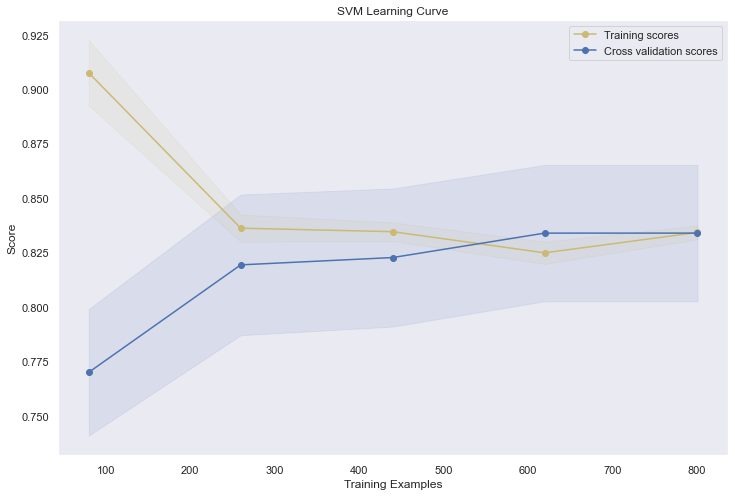

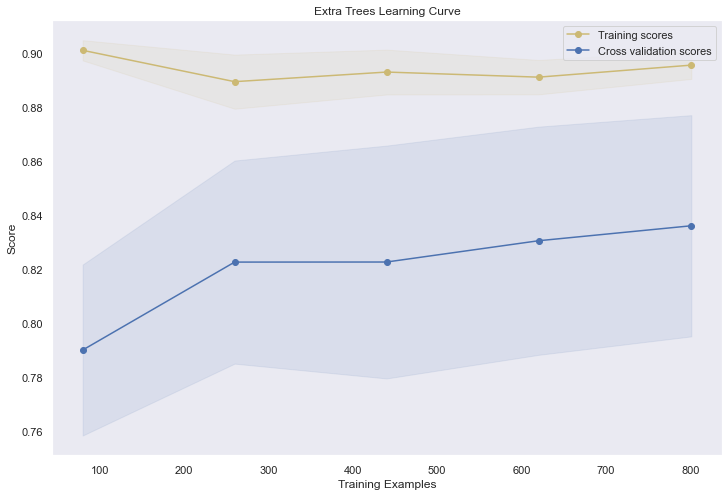

In [145]:
plot_learning_curve(best_ranFor,'Random Forest Learning Curve',
                    X_titanic_train_cleaned,y_titanic_train_cleaned,
                    cv=kfold)
plot_learning_curve(best_graBoo,'Gradient Boosting Learning Curve',
                    X_titanic_train_cleaned,y_titanic_train_cleaned,
                    cv=kfold)
plot_learning_curve(best_SVM,'SVM Learning Curve',
                    X_titanic_train_cleaned,y_titanic_train_cleaned,
                    cv=kfold)
plot_learning_curve(best_exTrees,'Extra Trees Learning Curve',
                    X_titanic_train_cleaned,y_titanic_train_cleaned,
                    cv=kfold)

- Observation:
    - overfitting in the gradiant boosting classifier seems to be consistently lower, even with very few training examples
    - although random forest has the best accuracy, its standard deviation is also the greatest
    - at 800 training examples, difference in accuracy between training and test sets are around the same 

# Feature importance

In [146]:
names_classifiers=[('Random Forest',best_ranFor),
                   ('Gradient Boosting',best_graBoo),             
                   ('Extra Trees',best_exTrees)]

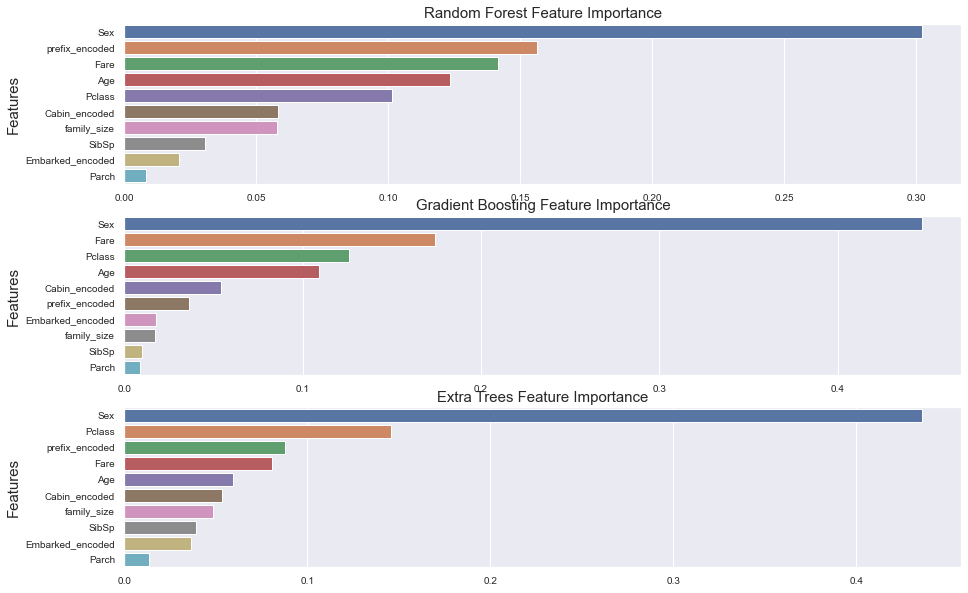

In [147]:
f, axes = plt.subplots(3,1 , figsize=(15, 10))
for i,classifier in enumerate(names_classifiers):
    indices=np.argsort(classifier[1].feature_importances_)[::-1]
    g=sb.barplot(y=X_titanic_train_cleaned.columns[indices],x=classifier[1].feature_importances_[indices],ax=axes[i])
    g.set_ylabel('Features',fontsize=15)
    g.tick_params(labelsize=10)
    g.set_title(classifier[0]+' Feature Importance',fontsize=15)

- Obervation:
    - Sex and prefix looks to be one of the top features in all three models (SVM doesn't allow feature importance)
    - family_size indeed was a stronger predictor compared to Parch and SibSp

# Ensemble modelling
- combining the predictions from the best models

In [148]:
VotingClassifier=VotingClassifier(estimators=[('Random Forest',best_ranFor),
                                                ('Gradient Boosting',best_graBoo),             
                                                ('Extra Trees',best_exTrees),
                                                 ('SVM',best_SVM)],
                                 voting='soft',
                                 n_jobs=-1)
VotingClassifier.fit(X_titanic_train_cleaned,y_titanic_train_cleaned)
                                                

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=8,
                                                     max_features=6,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=500,
                                                     n_jobs=None,
       

# Predicting on the test set  and submission

### ensemble model

In [149]:
test_predictions=pd.Series(VotingClassifier.predict(X_titanic_test_cleaned),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results['Survived']=results['Survived'].astype(int)
results.to_csv('ensemble_results.csv',index=False)

### random forest

In [150]:
test_predictions=pd.Series(best_ranFor.predict(X_titanic_test_cleaned),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results['Survived']=results['Survived'].astype(int)
results.to_csv('ranFor_results.csv',index=False)

### gradient boosting

In [151]:
test_predictions=pd.Series(best_graBoo.predict(X_titanic_test_cleaned),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results['Survived']=results['Survived'].astype(int)
results.to_csv('graBoo_results.csv',index=False)

### SVM

In [152]:
test_predictions=pd.Series(best_SVM.predict(X_titanic_test_cleaned),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results['Survived']=results['Survived'].astype(int)
results.to_csv('SVM_results.csv',index=False)

### extra Trees

In [153]:
test_predictions=pd.Series(best_exTrees.predict(X_titanic_test_cleaned),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results['Survived']=results['Survived'].astype(int)
results.to_csv('exTrees_results.csv',index=False)

# RESULTS

In [123]:
from IPython.display import Image

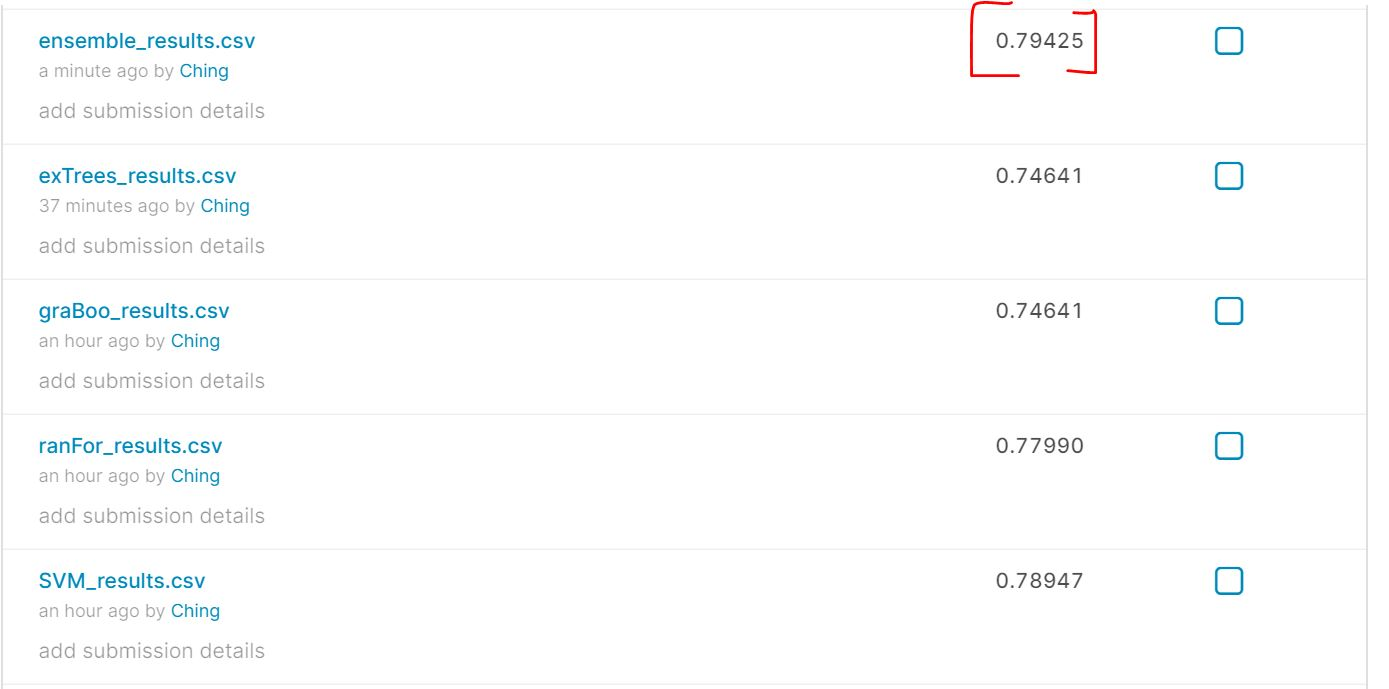

In [2]:
Image(filename='kaggle_scores.JPG')

- looks like different model need different input data to perform well:
    - after scaling the data and adjusting the data types, tree based models saw a significant drop in performance while SVM improved significantly

# catBoost
- much faster training time 
- provides categoric support
- performs better with less preprocessing required
- good default parameters, so performs well even without hypertuning

In [82]:
titanic_cleaned.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,family_size,Cabin_encoded,Embarked_encoded,prefix_encoded
0,0.273456,0.338125,0,3,1,1,0.0,2,7,2,1
1,0.473882,0.685892,0,1,0,1,1.0,2,2,0,2
2,0.323563,0.350727,0,3,0,0,1.0,1,7,2,2
3,0.436302,0.639463,0,1,0,1,1.0,2,2,2,2
4,0.436302,0.352955,0,3,1,0,0.0,1,7,2,1


- for catboost, i will keep variables: sex, pclass, cabin, embarked and prefix as categoric
- the remaining will be numeric

In [84]:
# convert to int type
for var in ['Parch','SibSp','family_size']:
    titanic_cleaned[var]=titanic_cleaned[var].astype(int)
    
# scale the numeric variables to speed up modelling
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()
titanic_processing[['Parch','SibSp','family_size']]=MMscaler.fit_transform(titanic_processing[['Parch','SibSp','family_size']])

In [93]:
# specifying categoric features for catboost
categoric_features=['Pclass', 'Sex', 'Cabin_encoded', 'Embarked_encoded', 'prefix_encoded']

In [85]:
titanic_cleaned.dtypes

Age                  float64
Fare                 float64
Parch                  int32
Pclass              category
Sex                 category
SibSp                  int32
Survived            category
family_size            int32
Cabin_encoded       category
Embarked_encoded    category
prefix_encoded      category
dtype: object

In [87]:
titanic_test_cleaned=titanic_cleaned[titanic_cleaned['Survived'].isna()]
titanic_train_cleaned=titanic_cleaned[~titanic_cleaned['Survived'].isna()]

- Steps:
    - split to the original training and test sets given

In [88]:
y_titanic_train_cleaned=titanic_train_cleaned['Survived']
X_titanic_train_cleaned=titanic_train_cleaned.drop(['Survived'],axis=1)
X_titanic_test_cleaned=titanic_test_cleaned.drop(['Survived'],axis=1)

- Steps:
    - separate predictor from response variable

In [94]:
%%time
from catboost import CatBoostClassifier,cv,Pool
params = {'loss_function':'Logloss',
          'eval_metric':'Accuracy',
          'verbose': 200,
          'random_seed': 1
         }

all_train_data = Pool(data=X_titanic_train_cleaned,
                      label=y_titanic_train_cleaned,
                      cat_features=categoric_features
                     )

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=5,
            seed=1, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8252027	test: 0.8181954	best: 0.8181954 (0)	total: 403ms	remaining: 6m 42s
200:	learn: 0.8790786	test: 0.8272157	best: 0.8339572 (28)	total: 53.1s	remaining: 3m 30s
400:	learn: 0.9119021	test: 0.8238638	best: 0.8339572 (28)	total: 1m 59s	remaining: 2m 58s
600:	learn: 0.9318215	test: 0.8272409	best: 0.8339572 (28)	total: 3m 17s	remaining: 2m 11s
800:	learn: 0.9475353	test: 0.8272346	best: 0.8339572 (28)	total: 4m 44s	remaining: 1m 10s
999:	learn: 0.9593169	test: 0.8317417	best: 0.8339572 (28)	total: 6m 14s	remaining: 0us
Wall time: 6min 15s


In [100]:
scores.tail()

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
995,995,0.831742,0.031244,0.959317,0.007807,0.429848,0.069382,0.152494,0.012211
996,996,0.831742,0.031244,0.959317,0.007807,0.429865,0.069257,0.152375,0.012176
997,997,0.831742,0.031244,0.959317,0.007807,0.429973,0.069274,0.152242,0.012188
998,998,0.831742,0.031244,0.959317,0.007807,0.429941,0.069264,0.152188,0.012181
999,999,0.831742,0.031244,0.959317,0.007807,0.429936,0.069199,0.152073,0.012148


- cross validation accuracy is 0.8317

In [121]:
test_predictions=pd.Series(cbc.predict(X_titanic_test_cleaned).astype(int),name='Survived')
results=pd.concat([titanic_test['PassengerId'],test_predictions],axis=1)
results.to_csv('catboost_results.csv',index=False)

In [117]:
cbc = CatBoostClassifier()
cbc.fit(all_train_data,
          use_best_model=True,
         )

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.009807
0:	learn: 0.6872351	total: 44.1ms	remaining: 44.1s
1:	learn: 0.6800825	total: 64.9ms	remaining: 32.4s
2:	learn: 0.6737864	total: 77ms	remaining: 25.6s
3:	learn: 0.6676777	total: 89ms	remaining: 22.2s
4:	learn: 0.6617828	total: 135ms	remaining: 26.9s
5:	learn: 0.6558911	total: 158ms	remaining: 26.2s
6:	learn: 0.6507341	total: 201ms	remaining: 28.5s
7:	learn: 0.6449713	total: 214ms	remaining: 26.6s
8:	learn: 0.6395370	total: 233ms	remaining: 25.7s
9:	learn: 0.6339749	total: 250ms	remaining: 24.8s
10:	learn: 0.6294139	total: 267ms	remaining: 24s
11:	learn: 0.6250751	total: 284ms	remaining: 23.4s
12:	learn: 0.6203513	total: 305ms	remaining: 23.2s
13:	learn: 0.6152054	total: 330ms	remaining: 23.3s
14:	learn: 0.6104763	total: 352ms	remaining: 23.1s
15:	learn: 0.6058467	total: 372ms	remaining: 22.9s
16:	learn: 0.6011796	total: 378ms	remaining: 21.9s
17:	learn: 0.5973267	total: 383ms	remaining: 20.9s
18:	learn: 0.5933944	total: 415ms	remaining: 21.4s
19:	learn: 0.

164:	learn: 0.3925869	total: 3.1s	remaining: 15.7s
165:	learn: 0.3924135	total: 3.1s	remaining: 15.6s
166:	learn: 0.3919736	total: 3.13s	remaining: 15.6s
167:	learn: 0.3915523	total: 3.15s	remaining: 15.6s
168:	learn: 0.3911290	total: 3.21s	remaining: 15.8s
169:	learn: 0.3908241	total: 3.23s	remaining: 15.8s
170:	learn: 0.3904715	total: 3.25s	remaining: 15.8s
171:	learn: 0.3900420	total: 3.31s	remaining: 15.9s
172:	learn: 0.3897956	total: 3.35s	remaining: 16s
173:	learn: 0.3895735	total: 3.39s	remaining: 16.1s
174:	learn: 0.3893876	total: 3.44s	remaining: 16.2s
175:	learn: 0.3890572	total: 3.46s	remaining: 16.2s
176:	learn: 0.3888453	total: 3.49s	remaining: 16.2s
177:	learn: 0.3883847	total: 3.53s	remaining: 16.3s
178:	learn: 0.3879659	total: 3.54s	remaining: 16.2s
179:	learn: 0.3876473	total: 3.54s	remaining: 16.1s
180:	learn: 0.3875138	total: 3.55s	remaining: 16.1s
181:	learn: 0.3872186	total: 3.57s	remaining: 16s
182:	learn: 0.3871359	total: 3.58s	remaining: 16s
183:	learn: 0.386743

325:	learn: 0.3605539	total: 6.8s	remaining: 14.1s
326:	learn: 0.3604734	total: 6.81s	remaining: 14s
327:	learn: 0.3604725	total: 6.83s	remaining: 14s
328:	learn: 0.3603045	total: 6.84s	remaining: 13.9s
329:	learn: 0.3601856	total: 6.86s	remaining: 13.9s
330:	learn: 0.3600280	total: 6.91s	remaining: 14s
331:	learn: 0.3599212	total: 6.93s	remaining: 13.9s
332:	learn: 0.3597177	total: 6.94s	remaining: 13.9s
333:	learn: 0.3595591	total: 6.97s	remaining: 13.9s
334:	learn: 0.3594606	total: 7.01s	remaining: 13.9s
335:	learn: 0.3592530	total: 7.04s	remaining: 13.9s
336:	learn: 0.3590481	total: 7.07s	remaining: 13.9s
337:	learn: 0.3588744	total: 7.1s	remaining: 13.9s
338:	learn: 0.3586625	total: 7.12s	remaining: 13.9s
339:	learn: 0.3584998	total: 7.16s	remaining: 13.9s
340:	learn: 0.3583576	total: 7.19s	remaining: 13.9s
341:	learn: 0.3582977	total: 7.2s	remaining: 13.8s
342:	learn: 0.3582061	total: 7.21s	remaining: 13.8s
343:	learn: 0.3580469	total: 7.25s	remaining: 13.8s
344:	learn: 0.3579042

490:	learn: 0.3396549	total: 10.5s	remaining: 10.9s
491:	learn: 0.3394232	total: 10.5s	remaining: 10.8s
492:	learn: 0.3393023	total: 10.5s	remaining: 10.8s
493:	learn: 0.3391056	total: 10.5s	remaining: 10.8s
494:	learn: 0.3389348	total: 10.5s	remaining: 10.8s
495:	learn: 0.3387556	total: 10.6s	remaining: 10.8s
496:	learn: 0.3386758	total: 10.6s	remaining: 10.8s
497:	learn: 0.3385772	total: 10.7s	remaining: 10.7s
498:	learn: 0.3385676	total: 10.7s	remaining: 10.7s
499:	learn: 0.3385068	total: 10.7s	remaining: 10.7s
500:	learn: 0.3383458	total: 10.7s	remaining: 10.7s
501:	learn: 0.3382650	total: 10.8s	remaining: 10.7s
502:	learn: 0.3381148	total: 10.8s	remaining: 10.7s
503:	learn: 0.3380181	total: 10.8s	remaining: 10.6s
504:	learn: 0.3378704	total: 10.8s	remaining: 10.6s
505:	learn: 0.3377774	total: 10.9s	remaining: 10.6s
506:	learn: 0.3376803	total: 10.9s	remaining: 10.6s
507:	learn: 0.3375604	total: 11s	remaining: 10.6s
508:	learn: 0.3373868	total: 11s	remaining: 10.6s
509:	learn: 0.33

649:	learn: 0.3237806	total: 14.7s	remaining: 7.91s
650:	learn: 0.3236629	total: 14.7s	remaining: 7.88s
651:	learn: 0.3235842	total: 14.7s	remaining: 7.85s
652:	learn: 0.3235271	total: 14.7s	remaining: 7.83s
653:	learn: 0.3235023	total: 14.7s	remaining: 7.8s
654:	learn: 0.3234030	total: 14.8s	remaining: 7.79s
655:	learn: 0.3233709	total: 14.8s	remaining: 7.77s
656:	learn: 0.3232050	total: 14.8s	remaining: 7.74s
657:	learn: 0.3231364	total: 14.9s	remaining: 7.72s
658:	learn: 0.3229433	total: 14.9s	remaining: 7.71s
659:	learn: 0.3229395	total: 14.9s	remaining: 7.69s
660:	learn: 0.3228761	total: 14.9s	remaining: 7.66s
661:	learn: 0.3227935	total: 14.9s	remaining: 7.63s
662:	learn: 0.3227835	total: 15s	remaining: 7.61s
663:	learn: 0.3226606	total: 15s	remaining: 7.6s
664:	learn: 0.3226138	total: 15s	remaining: 7.58s
665:	learn: 0.3225762	total: 15.1s	remaining: 7.56s
666:	learn: 0.3224675	total: 15.1s	remaining: 7.55s
667:	learn: 0.3223307	total: 15.2s	remaining: 7.54s
668:	learn: 0.322246

811:	learn: 0.3097517	total: 19.5s	remaining: 4.51s
812:	learn: 0.3097100	total: 19.5s	remaining: 4.48s
813:	learn: 0.3097049	total: 19.5s	remaining: 4.46s
814:	learn: 0.3096788	total: 19.5s	remaining: 4.44s
815:	learn: 0.3095223	total: 19.6s	remaining: 4.42s
816:	learn: 0.3095188	total: 19.6s	remaining: 4.39s
817:	learn: 0.3093325	total: 19.7s	remaining: 4.37s
818:	learn: 0.3092385	total: 19.7s	remaining: 4.35s
819:	learn: 0.3090325	total: 19.7s	remaining: 4.33s
820:	learn: 0.3089877	total: 19.8s	remaining: 4.31s
821:	learn: 0.3088984	total: 19.8s	remaining: 4.28s
822:	learn: 0.3086837	total: 19.8s	remaining: 4.26s
823:	learn: 0.3086022	total: 19.9s	remaining: 4.24s
824:	learn: 0.3085882	total: 19.9s	remaining: 4.22s
825:	learn: 0.3085031	total: 19.9s	remaining: 4.19s
826:	learn: 0.3084340	total: 19.9s	remaining: 4.17s
827:	learn: 0.3083771	total: 20s	remaining: 4.15s
828:	learn: 0.3081693	total: 20s	remaining: 4.13s
829:	learn: 0.3079763	total: 20s	remaining: 4.1s
830:	learn: 0.30781

973:	learn: 0.2954479	total: 25.5s	remaining: 680ms
974:	learn: 0.2953173	total: 25.5s	remaining: 654ms
975:	learn: 0.2952507	total: 25.5s	remaining: 627ms
976:	learn: 0.2950647	total: 25.5s	remaining: 601ms
977:	learn: 0.2950228	total: 25.6s	remaining: 575ms
978:	learn: 0.2949943	total: 25.6s	remaining: 549ms
979:	learn: 0.2949335	total: 25.6s	remaining: 522ms
980:	learn: 0.2948731	total: 25.7s	remaining: 497ms
981:	learn: 0.2947354	total: 25.7s	remaining: 471ms
982:	learn: 0.2945918	total: 25.8s	remaining: 446ms
983:	learn: 0.2945300	total: 25.8s	remaining: 419ms
984:	learn: 0.2943522	total: 25.8s	remaining: 393ms
985:	learn: 0.2942469	total: 25.9s	remaining: 368ms
986:	learn: 0.2941555	total: 25.9s	remaining: 342ms
987:	learn: 0.2941319	total: 26s	remaining: 316ms
988:	learn: 0.2941173	total: 26s	remaining: 289ms
989:	learn: 0.2940729	total: 26.1s	remaining: 263ms
990:	learn: 0.2938572	total: 26.1s	remaining: 237ms
991:	learn: 0.2937100	total: 26.2s	remaining: 211ms
992:	learn: 0.29

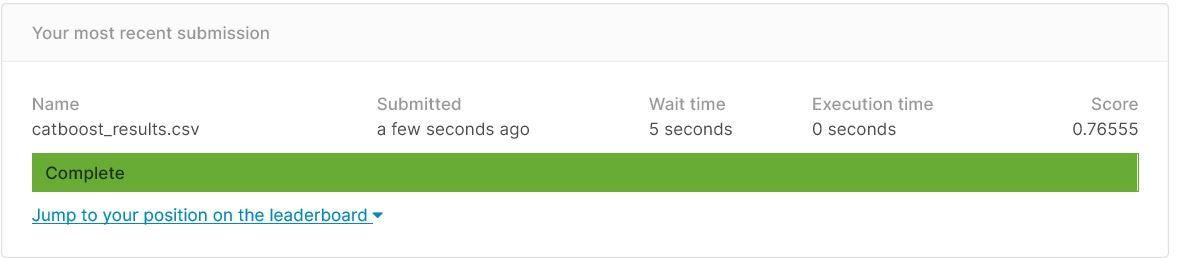

In [124]:
Image(filename='catboost_scores.JPG')